In [1]:
from typing import List, Dict, Tuple, Callable
import itertools
import math
import os
import pickle
from copy import deepcopy

import casadi as cas
import numpy as np
from scipy import signal
from dataclasses import dataclass
import matplotlib.pyplot as plt

from IOData.IOData import IOData, InputRule
from IOData.IODataWith_l import IODataWith_l
from System.ErrorKinematicAcceLATI import LinearizedErrorKinematicAcceModel, LinearizedErrorKinematicAcceModelParams, KinematicAcceModelParams
from tools.simualtion_results import Results, PlotStyle
from tools.dataset_analyse import get_datasets_hankel_matrix

In [2]:
def fractal_dimension(
        locs: np.ndarray, region_min: np.ndarray, region_max: np.ndarray,
        max_box_size: float = None, min_box_size: float = -3.0,
        n_samples: int = 20, n_offsets: float = 0, plot = False) -> Tuple[float, np.ndarray, np.ndarray]:
    """Calculates the fractal dimension of a 3D numpy array.
    Returns: 
        float: the fractal dimension
        np.ndarray: the log of the number of boxes N(s) needed to cover the graph
        np.ndarray: the log of the inverse of the box size 1/s

    Args:
        locs (np.ndarray): locations where the graph is marked as 1. 
                            Of the form [[point1], [point2], ...]
        region_min (np.ndarray): minimum values of the region of interest.
        region_max (np.ndarray): maximum values of the region of interest.
        max_box_size (float): The largest box size, given as the power of 2 so that
                            2**max_box_size gives the sidelength of the largest box.                     
        min_box_size (float): The smallest box size, given as the power of 2 so that
                            2**min_box_size gives the sidelength of the smallest box.
                            Default value 1.
        n_samples (int): number of scales to measure over.
        n_offsets (float): number of offsets to search over to find the smallest set N(s) to
                       cover  all voxels>0.
        plot (bool): set to true to see the analytical plot of a calculation.
                            
        
    """
    #determine the scales to measure on
    if max_box_size == None:
        #default max size is the largest power of 2 that fits in the smallest dimension of the array:
        max_box_size = np.log2(np.min(region_max - region_min))
    scales = np.logspace(max_box_size, min_box_size, num=n_samples, base=2)
    
    #count the minimum amount of boxes touched
    Ns = []
    #loop over all scales
    for scale in scales:
        touched = []
        if n_offsets == 0:
            offsets = [0]
        else:
            offsets = np.linspace(0, scale, n_offsets)
        #search over all offsets
        for offset in offsets:
            bin_edges = [np.arange(min_el-offset, max_el+scale, scale) for min_el, max_el in zip(region_min, region_max)]
            H1, e = np.histogramdd(locs, bins = bin_edges)
            touched.append(np.sum(H1>0))
        Ns.append(touched)
    Ns = np.array(Ns)
    
    #From all sets N found, keep the smallest one at each scale
    Ns = Ns.min(axis=1)
   
    
    #Only keep scales at which Ns changed
    scales  = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    
    
    Ns = np.unique(Ns)
    Ns = Ns[Ns > 0]
    scales = scales[:len(Ns)]
    #perform fit
    coeffs = np.polyfit(np.log2(1/scales), np.log2(Ns),1)
    
    #make plot
    if plot:
        fig, ax = plt.subplots(figsize = (8,6))
        ax.scatter(np.log2(1/scales), np.log2(np.unique(Ns)), c = "teal", label = "Measured ratios")
        ax.set_ylabel(r"$\log_2 N(\epsilon)$")
        ax.set_xlabel(r"$\log_2 1/ \epsilon$")
        fitted_y_vals = np.polyval(coeffs, np.log2(1/scales))
        ax.plot(np.log2(1/scales), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
        ax.legend()
    
    return coeffs[0], np.log2(Ns), np.log2(1/scales)

In [3]:
class DoubleIntegratorWithDrag:
    _state: np.ndarray # actual state of the system, [x, dot_x]
    @property
    def state(self):
        return self._state
    @state.setter
    def state(self, state: np.ndarray):
        self._state = state

    _x: cas.SX # state vector of system
    _u: cas.SX # input vector of system
    _f: cas.SX # dynamics of system
    _F_c_r: cas.Function # casadi integrator for the ode function

    Ts: float # sampling time of system
    beta: float # drag coefficient of system

    u_min: float # minimum input of system
    u_max: float # maximum input of system

    x_min: np.ndarray # minimum state of system
    x_max: np.ndarray # maximum state of system

    @property
    def m(self):
        return 1
    
    @property
    def n(self):
        return 2
    
    @property
    def p(self):
        return 2
    
    @property
    def A_u(self):
        return np.matrix("1;-1")
    
    @property
    def b_u(self):
        return np.matrix([[self.u_max],[-self.u_min]])
    
    @property
    def A_y(self):
        return np.matrix("1 0; 0 1; -1 0; 0 -1")
    
    @property
    def b_y(self):
        return np.matrix([[self.x_max[0]], [self.x_max[1]], [-self.x_min[0]], [-self.x_min[1]]])

    def __init__(self, Ts: float, beta: float, g: float,
                 init_state: np.ndarray = np.array([0, 0]),
                 u_min: float = -1, u_max: float = 1,
                 x_min: np.ndarray = np.array([-np.inf, -np.inf]),
                 x_max: np.ndarray = np.array([np.inf, np.inf])):
        self.Ts = Ts
        self.g = g
        self.beta = beta
        self._state = init_state
        self.u_min = u_min
        self.u_max = u_max
        self.x_min = x_min
        self.x_max = x_max

        self._x = cas.SX.sym('x', 2)
        self._u = cas.SX.sym('u', 1)
        self._f = cas.SX.sym('f', 2)

        self._f[0] = 3 * self._x[1]
        self._f[1] = self._u[0] - self.g * cas.sin(self._x[0]) - self.beta * cas.cos(10*self._x[1]**2) ** 2 * self._x[0]
        # self._f[1] = self._u[0]

        ode = {'x': self._x, 'u': self._u, 'ode': self._f}
        self._F_c_r = cas.integrator('F', 'cvodes', ode, 0, self.Ts)

    def step(self, u: np.matrix) -> Tuple[np.matrix, np.matrix]:
        return self.step_lin(u)
    
    def step_lin(self, u: np.matrix) -> Tuple[np.matrix, np.matrix]:
        u_array = np.array(u).flatten()
        initial_state = self._state
        x_matrix = np.matrix(self._state).T

        ode_results = self._F_c_r(x0=initial_state, u=u_array)
        self._state = np.array(ode_results['xf']).flatten()
        return x_matrix, np.matrix(np.zeros((2, 1)))

In [4]:
class Predictor:
    """Predictor for system, use STATE as initial condition!"""
    L: int
    weight_xi: np.matrix # weight matrix for xi, used for weighting trajectory slices
    f: Callable[[float], float] # function for evaluating weight of trajectory slice, w = f(d)
    d_range: float # ommit all trajectory slices with d > d_range
    min_num_slices: int # minimum number of slices to be used for prediction
    portion_slices: float # portion of slices to be used for prediction

    io_data_list: List[IOData]
    remove_old_data: bool # if true, remove old data when new data added
    system: DoubleIntegratorWithDrag

    def __init__(self, L: int,
                 system: DoubleIntegratorWithDrag,
                 io_data_list: List[IOData] = [],
                 remove_old_data: bool = False,
                 d_range: float = np.inf,):
        self.L = L
        self.system = system
        self.io_data_list = io_data_list
        self.remove_old_data = remove_old_data
        self.d_range = d_range
    
    def get_hankel_matrix(self) -> Tuple[np.matrix, np.matrix, np.matrix]:
        """Get the !!STATE!! hankel matrix of the system

        return: H_x_past, H_u_future, H_x_future
        """
        H_x_past = np.matrix(np.zeros((self.system.n, 0)))
        H_u_future = np.matrix(np.zeros((self.system.m*self.L, 0)))
        H_x_future = np.matrix(np.zeros((self.system.n*self.L, 0)))
        for io_data in self.io_data_list:
            if io_data.length < self.L + 1:
                continue
            io_data.update_depth(self.L+1) # since we are using full-state observation, only one step needed for initial condition
            H_x_past = np.hstack((H_x_past, io_data.H_output_noised_part((0, 1))))
            H_u_future = np.hstack((H_u_future, io_data.H_input_part((0, self.L))))
            H_x_future = np.hstack((H_x_future, io_data.H_output_part((1, self.L+1))))
        return H_x_past, H_u_future, H_x_future

    def get_estimation_matrix(self, x_t: np.matrix) -> np.matrix:
        """
        Get estimation matrix for given x_t, which is the initial state of system
        xi: extended initial condition, of shape (lag * (m + p), 1)
        """
        m = self.io_data_list[0]._input_data[0].shape[0]
        p = self.io_data_list[0]._output_data[0].shape[0]
        H_x_past, H_u_future, H_x_future = self.get_hankel_matrix()
        width_H = H_x_past.shape[1]

        delta_H_x_t  = H_x_past - x_t
        d_array = np.zeros((width_H,))
        for i in range(width_H):
            d_array[i] = np.sqrt((delta_H_x_t[:,i].T @ self.weight_xi @ delta_H_x_t[:,i])[0,0])

        # find a proper diatance range
        num_slices = max(self.min_num_slices, int(self.portion_slices*width_H))
        d_range = max(self.d_range, np.partition(d_array, num_slices)[num_slices])
        # print("d_range: ", d_range)

        d_inv_array = np.zeros((width_H,))
        for i in range(width_H-1, 0, -1):
            if d_array[i] < self.d_range:
                d_inv_array[i] = self.f(d_array[i])
            else:
                # np.delete(d_array, i)
                # np.delete(H_x_past, i, axis=1)
                # np.delete(H_u_future, i, axis=1)
                # np.delete(H_x_future, i, axis=1)
                d_inv_array[i] = 0
        D_inv = np.diag(d_inv_array)

        # calculate the estimation matrix
        H_x_past_u_future_1 = np.vstack(( H_x_past, H_u_future, np.matrix(np.ones((1, width_H))) ))
        D_inv_Hxuf_T = D_inv @ H_x_past_u_future_1.T
        Phi = H_x_future @ D_inv_Hxuf_T @ np.linalg.pinv(H_x_past_u_future_1 @ D_inv_Hxuf_T)

        return Phi

    def prediction_error(self, x_t: np.matrix, u_future: List[np.matrix], W_x: np.matrix) -> float:
        """
        Get the prediction error using weighting matrix W_x
        """
        y_predicted_list = self.predict(x_t, u_future)
        y_real_list = self.propogate_real_system(x_t, u_future)
        error = 0

        for y_predicted, y_real in zip(y_predicted_list, y_real_list):
            error += ((y_predicted - y_real).T @ W_x @ (y_predicted - y_real))[0,0]
        
        return error

    def predict(self, x_t: np.matrix, u_future: List[np.matrix]) -> List[np.matrix]:
        """
        Predict future states of the system
        Args:
            xi: extended initial condition, of shape (lag * (m + p), 1)
            u_future: list of future states to be applied
        Return:
            y_future: list of future states to be applied
        """
        Phi = self.get_estimation_matrix(x_t)
        u_future_matrix = np.vstack(u_future)
        y_L = Phi[:,self.system.n:-1] @ u_future_matrix + Phi[:,:self.system.n] @ x_t + Phi[:,-1]
        
        return np.split(y_L, self.L)
    
    def propogate_real_system(self, x_t: np.matrix, u_future: List[np.matrix]) -> List[np.matrix]:
        """
        Get the real states of the system
        Args:
            xi: extended initial condition, of shape (lag * (m + p), 1)
            u_future: list of future states to be applied
        Return:
            y_future: list of future states to be applied
        """
        # set state of system to x_t
        self.system.state = np.array(x_t).flatten()
        # propogate system
        # last input does not matter, so use zero
        u_future.append(np.matrix(np.zeros((self.system.m, 1))))
        y_future = []
        for u in u_future:
            y_future.append(self.system.step(u)[0])
        
        return y_future[1:] # remove the first one, which is the initial condition
    
    def add_io_data(self, io_data: IOData):
        self.io_data_list.append(io_data)
    
    def add_data_point(self, u: np.matrix, y: np.matrix, n: np.matrix, use_new_dataset: bool, remove_old_data: bool = False):
        if use_new_dataset:
            self.io_data_list.append(IOData(depth=self.L+self.lag, m=self.system.m, n=self.system.n, p=self.system.p))
        
        self.io_data_list[-1].add_point(u, y, n)
        if remove_old_data:
            self.io_data_list[0].remove_last_point()
            if self.io_data_list[0].length < self.lag+self.L:
                self.io_data_list.pop(0)
    
    


(1, 1)
(2, 1)


Text(0, 0.5, 'dot_x')

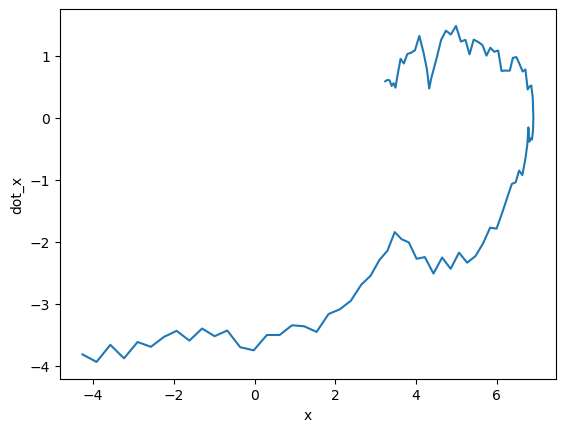

In [5]:
Ts = 0.03
beta = 0.5
g = 0.5
u_max = 10
x_max = np.array([np.pi, 0.5])
u_min = - u_max
x_min = - x_max

initial_state = x_max
system = DoubleIntegratorWithDrag(Ts=Ts, beta=beta, g=g, u_max=u_max, u_min=u_min, init_state=initial_state)

np.random.seed(0)

io_data_test = IOData(depth = 2, sys=system, length=100, input_rule=InputRule.RANDOM)
print(io_data_test._input_data[0].shape)
print(io_data_test._output_data[0].shape)
plt.plot([y[0,0] for y in io_data_test._output_data], [y[1,0] for y in io_data_test._output_data])
plt.xlabel("x")
plt.ylabel("dot_x")

Text(0, 0.5, '$x_2$')

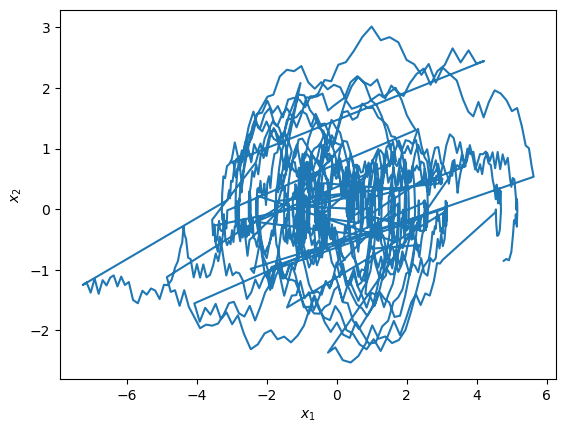

In [6]:
N_grid_x_0_data = 10
N_grid_x_1_data = 4

N_grid_x_0 = 10
N_grid_x_1 = 10
N_grid_u = 10

x_0_grid_data = np.linspace(x_min[0], x_max[0], N_grid_x_0_data)
x_1_grid_data = np.linspace(x_min[1], x_max[1], N_grid_x_1_data)

x_0_grid = np.linspace(x_min[0], x_max[0], N_grid_x_0)
x_1_grid = np.linspace(x_min[1], x_max[1], N_grid_x_1)
u_grid = np.linspace(u_min, u_max, N_grid_u)

d_range = 0.1
num_slices = 300
portion_slices = 0.1
L = 3
W_x = np.diag((1/(x_max - x_min))**2)
# f = lambda d: (1/(d_range+d)) ** 2
f = lambda d: np.exp(-d)

np.random.seed(0)

length_list = np.array([50, 100, 150, 200, 250, 300])
diff_list = np.diff(length_list)
io_data_list_list: List[List[IOData]] = []
io_data_list = []
for x_0, x_1 in itertools.product(x_0_grid_data, x_1_grid_data):
    # print(x_0, x_1)
    system_for_data = deepcopy(system)
    system_for_data.state = np.array([x_0, x_1])
    io_data_list.append(IOData(depth=2, sys=system_for_data, length=length_list[0], input_rule=InputRule.RANDOM))
io_data_list_list.append(deepcopy(io_data_list))

for diff_length in diff_list:
    io_data_list = deepcopy(io_data_list_list[-1])
    for io_data in io_data_list:
        # set the state and step the system for one step
        system_for_data.state = np.array(io_data._output_data[-1]).flatten()
        system_for_data.step(io_data._input_data[-1])

        # step the system and add new data
        for _ in range(diff_length):
            u = io_data.get_input(io_data.length-1, system_for_data, InputRule.RANDOM)
            y, n = system_for_data.step(u)
            io_data.add_point(u, y, n)
    io_data_list_list.append(deepcopy(io_data_list))
        

predictor = Predictor(L=1, system=system, io_data_list=io_data_list_list[0], remove_old_data=False, d_range=d_range)
predictor.min_num_slices = num_slices
predictor.portion_slices = portion_slices
H_x_past, H_u_future, H_x_future = predictor.get_hankel_matrix()
plt.plot(H_x_past[0,:].T, H_x_past[1,:].T)
# plt.xlim(x_min[0]-0.1*(x_max[0]-x_min[0]), x_max[0]+0.1*(x_max[0]-x_min[0]))
# plt.ylim(x_min[1]-0.1*(x_max[1]-x_min[1]), x_max[1]+0.1*(x_max[1]-x_min[1]))
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

In [7]:
predictor.weight_xi = W_x
predictor.f = f

predictor.L = L
error_list_list: List[np.ndarray] = []
for length, io_data_list in zip(length_list, io_data_list_list):
    error_list = np.zeros((N_grid_x_0, N_grid_x_1, N_grid_u))
    print("length: ", io_data_list[0].length)
    predictor.io_data_list = io_data_list
    for i, j, k in itertools.product(range(N_grid_x_0), range(N_grid_x_1), range(N_grid_u)):
        x_0 = x_0_grid[i]
        x_1 = x_1_grid[j]
        u = u_grid[k]
        x_t = np.matrix([[x_0], [x_1]])
        u_future = [np.matrix([[u]]) for _ in range(predictor.L)]
        error_list[i,j,k] = predictor.prediction_error(x_t, u_future, W_x)
    print("Average of Error", np.average(error_list.flatten()))
    print("Maximum of Error", np.max(error_list.flatten()))
    error_list_list.append(error_list)

length:  50
Average of Error 0.03168515141446129
Maximum of Error 7.628421785471739
length:  100
Average of Error 0.0009486638087342155
Maximum of Error 0.02812258309703853
length:  150
Average of Error 0.0005817142356772796
Maximum of Error 0.012173027686673134
length:  200
Average of Error 0.000562035831231277
Maximum of Error 0.012024379951633449
length:  250
Average of Error 0.000528886974996032
Maximum of Error 0.012174286372621843
length:  300
Average of Error 0.0005052693592284923
Maximum of Error 0.011054268754801764


[-9.99852601 -7.37207548 -2.52846615]
[0.59994112 0.53459553 0.64381101]
(2000, 3)
[ -9.99855101 -15.27545601  -4.57839756]
[0.60001824 0.54572777 0.49698547]
(4000, 3)
[ -9.99855101 -15.42173095  -4.57839756]
[0.60001824 0.55753313 0.58075747]
(6000, 3)
[ -9.99855101 -15.42173095  -5.78751272]
[0.60001824 0.57502935 0.59045625]
(8000, 3)
[ -9.99855101 -19.70880893  -6.01132535]
[0.6000252  0.61305361 0.58097861]
(10000, 3)


KeyboardInterrupt: 

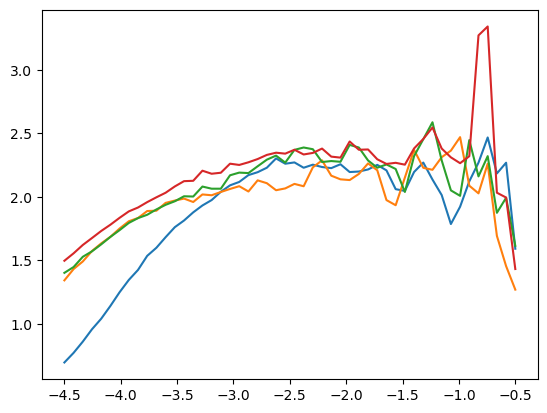

In [8]:
# dimension of whole shape
io_data_list = io_data_list_list[0]

size_min = -5
size_max = 0
N_size_step = 50
size_length = 1.0
n_sample = 15
n_offset = 15

middle_points = np.linspace(size_max-size_length/2, size_min+size_length/2, N_size_step)
size_ranges = [(middle_point + size_length/2, middle_point - size_length/2) for middle_point in middle_points]
d_list_list = []

fig, ax = plt.subplots()
for io_data_list in io_data_list_list:
    H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
    # print(H_ux[:,0:2])
    locs = np.array(H_ux.T) # normalize data
    # print(locs[0:2,:])

    # region_min = np.hstack([u_min, x_min])
    # region_max = np.hstack([u_max, x_max])
    region_min = np.min(locs, axis=0)
    region_max = np.max(locs, axis=0)
    mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
    locs = locs[mask]

    region_size = region_max - region_min
    regin_min = region_min - 0.1 * region_size
    region_max = region_max + 0.1 * region_size

    regin_min = regin_min/region_size
    region_max = region_max/region_size
    locs = locs/region_size
    print(region_min)
    print(region_max)
    print(locs.shape)
    d_list = []
    for size_range in size_ranges:
        # print(size_range)
        d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=size_range[0], min_box_size=size_range[1], n_samples=n_sample, n_offsets=n_offset, plot=False)
        d_list.append(d)
    ax.plot(middle_points, d_list, label="single trajectory length: "+str(io_data_list[0].length))
    d_list_list.append(d_list)
ax.set_ylim(1.5, 2.8)
ax.legend()
ax.set_ylabel(r"Fitted box-counting dimension")
ax.set_xlabel(r"Middle point of box-size range (log scale)")


40
50
[-9.99852601 -7.37207548 -2.52846615]
[0.59994112 0.53459553 0.64381101]
(2000, 3)
2.179212951945834


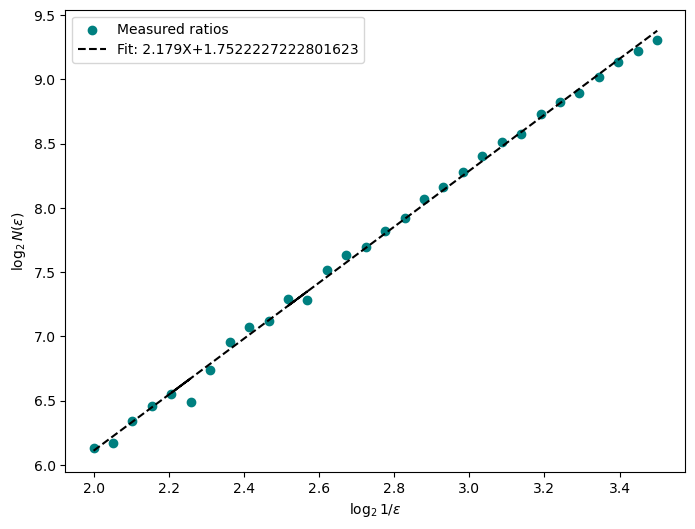

In [28]:
io_data_list = io_data_list_list[0]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.0, min_box_size=-3.5, n_samples=30, n_offsets=20, plot=True)
print(d)

40
100
[ -9.99855101 -15.27545601  -4.57839756]
[0.60001824 0.54572777 0.49698547]
(4000, 3)
2.046231731178489


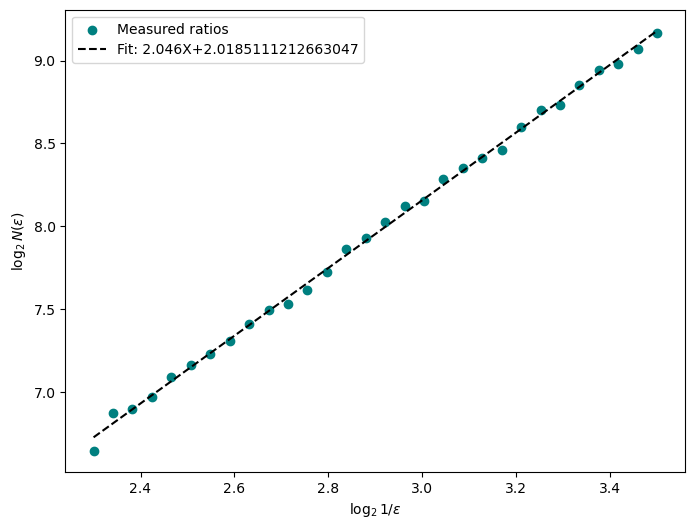

In [29]:
io_data_list = io_data_list_list[1]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.3, min_box_size=-3.5, n_samples=30, n_offsets=20, plot=True)
print(d)

40
150
[ -9.99855101 -15.42173095  -4.57839756]
[0.60001824 0.55753313 0.58075747]
(6000, 3)
2.203635246136824


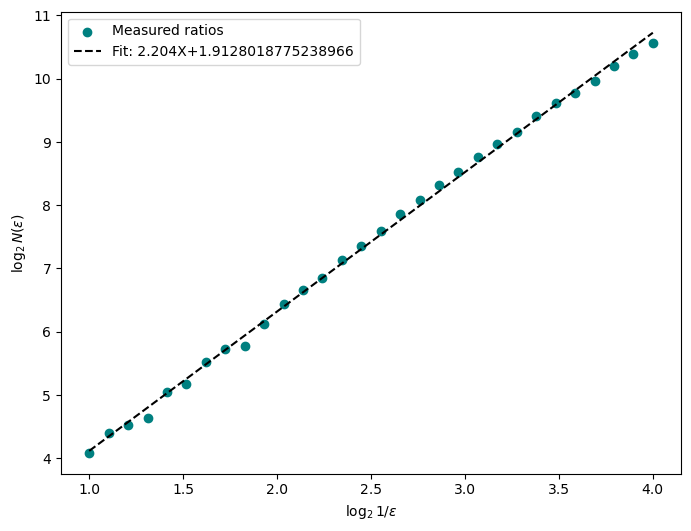

In [30]:
io_data_list = io_data_list_list[2]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-1, min_box_size=-4, n_samples=30, n_offsets=20, plot=True)
print(d)

40
200
[ -9.99855101 -15.42173095  -5.78751272]
[0.60001824 0.57502935 0.59045625]
(8000, 3)
2.3006021191678934


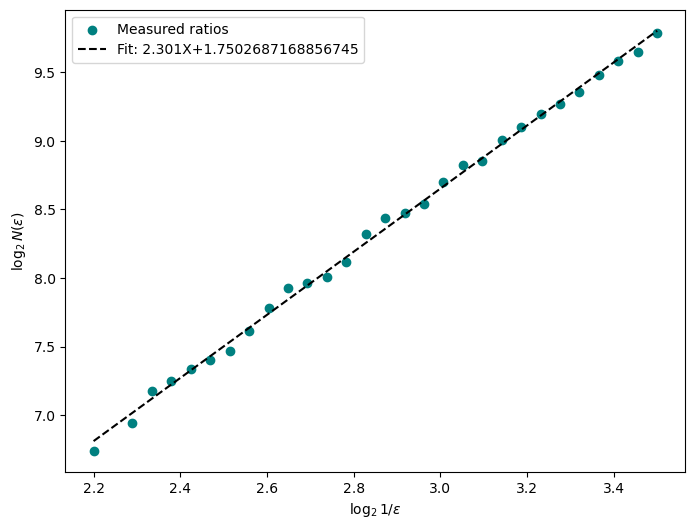

In [31]:
io_data_list = io_data_list_list[3]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.2, min_box_size=-3.5, n_samples=30, n_offsets=20, plot=True)
print(d)

40
250
[ -9.99855101 -19.70880893  -6.01132535]
[0.6000252  0.61305361 0.58097861]
(10000, 3)
2.3241831592336912


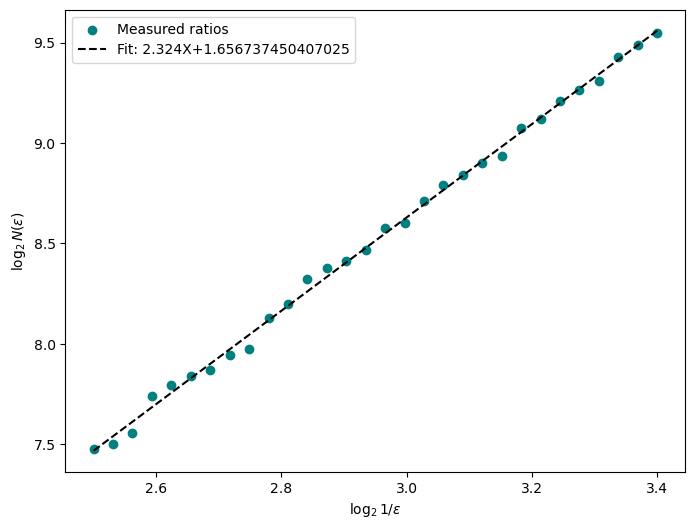

In [32]:
io_data_list = io_data_list_list[4]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3.4, n_samples=30, n_offsets=20, plot=True)
print(d)

40
300
[ -9.99855101 -19.88028137  -6.01132535]
[0.6000252  0.61088919 0.60281495]
(12000, 3)
2.338905230735961


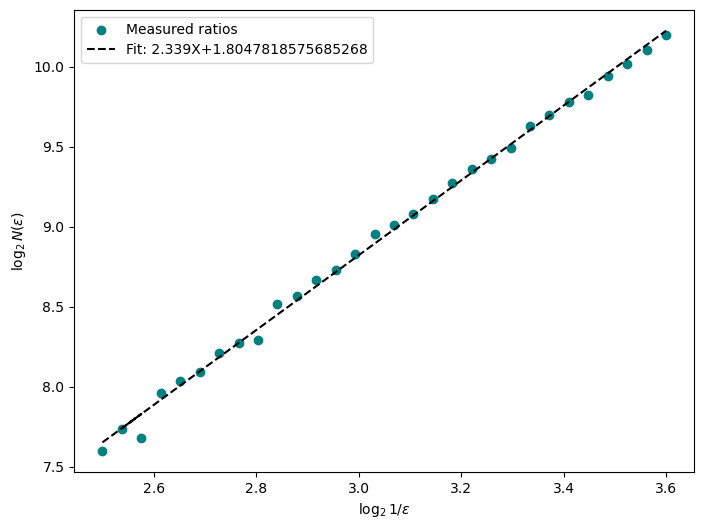

In [33]:
io_data_list = io_data_list_list[5]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3.6, n_samples=30, n_offsets=20, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(843, 3)
[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1326, 3)
[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1566, 3)
[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1801, 3)
[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(2013, 3)
[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(2161, 3)


Text(0.5, 0, 'Middle point of box-size range (log scale)')

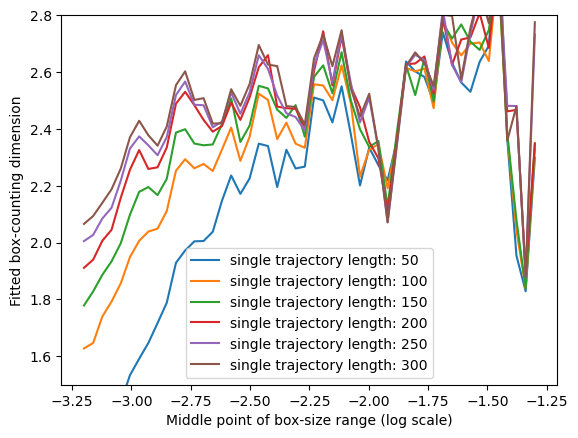

In [21]:
# dimension within region
size_min = -3.5
size_max = -1
N_size_step = 50
size_length = 0.6
n_sample = 15
n_offset = 15

middle_points = np.linspace(size_max-size_length/2, size_min+size_length/2, N_size_step)
size_ranges = [(middle_point + size_length/2, middle_point - size_length/2) for middle_point in middle_points]
d_list_list = []

fig, ax = plt.subplots()
for io_data_list in io_data_list_list:
    H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
    # print(H_ux[:,0:2])
    locs = np.array(H_ux.T) # normalize data
    # print(locs[0:2,:])

    region_min = np.hstack([u_min, x_min])
    region_max = np.hstack([u_max, x_max])
    # region_min = np.min(locs, axis=0)
    # region_max = np.max(locs, axis=0)
    mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
    locs = locs[mask]

    region_size = region_max - region_min
    regin_min = region_min - 0.1 * region_size
    region_max = region_max + 0.1 * region_size

    regin_min = regin_min/region_size
    region_max = region_max/region_size
    locs = locs/region_size
    print(region_min)
    print(region_max)
    print(locs.shape)
    d_list = []
    for size_range in size_ranges:
        # print(size_range)
        d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=size_range[0], min_box_size=size_range[1], n_samples=n_sample, n_offsets=n_offset, plot=False)
        d_list.append(d)
    ax.plot(middle_points, d_list, label="single trajectory length: "+str(io_data_list[0].length))
    d_list_list.append(d_list)
ax.set_ylim(1.5, 2.8)
ax.legend()
ax.set_ylabel(r"Fitted box-counting dimension")
ax.set_xlabel(r"Middle point of box-size range (log scale)")

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(843, 3)
2.091703513586301


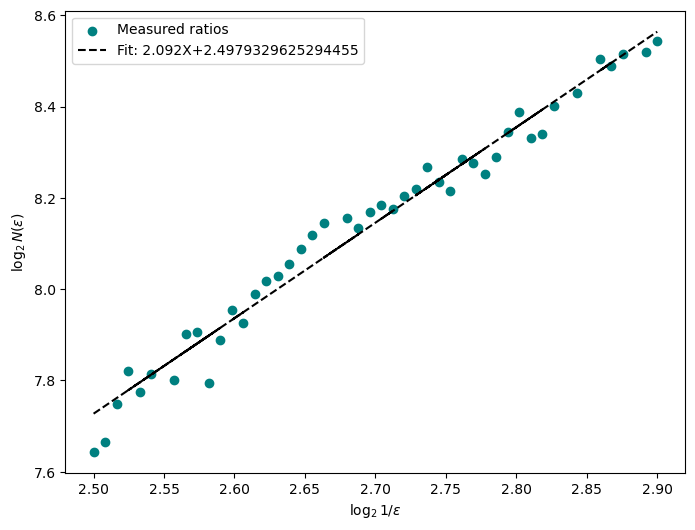

In [40]:
io_data_list = io_data_list_list[0]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-2.9, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1326, 3)
2.2720095622402137


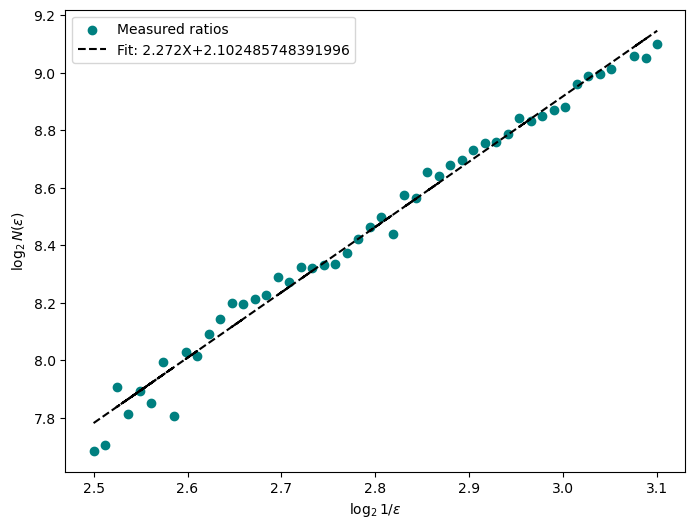

In [41]:
io_data_list = io_data_list_list[1]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3.1, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1566, 3)
2.390773219464361


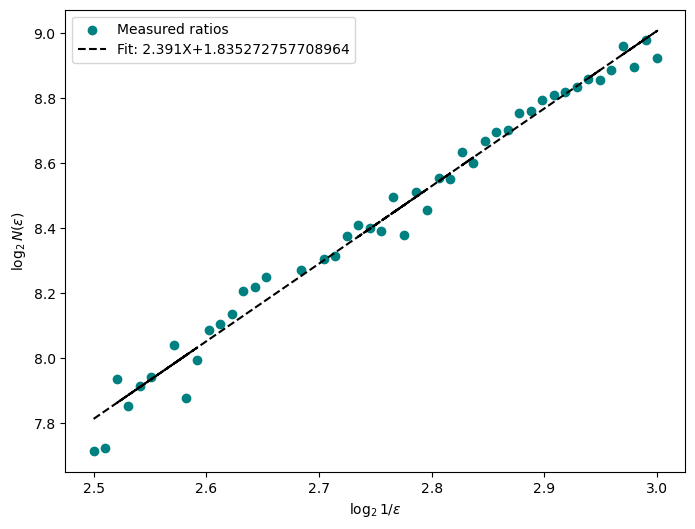

In [42]:
io_data_list = io_data_list_list[2]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1801, 3)
2.467237755295315


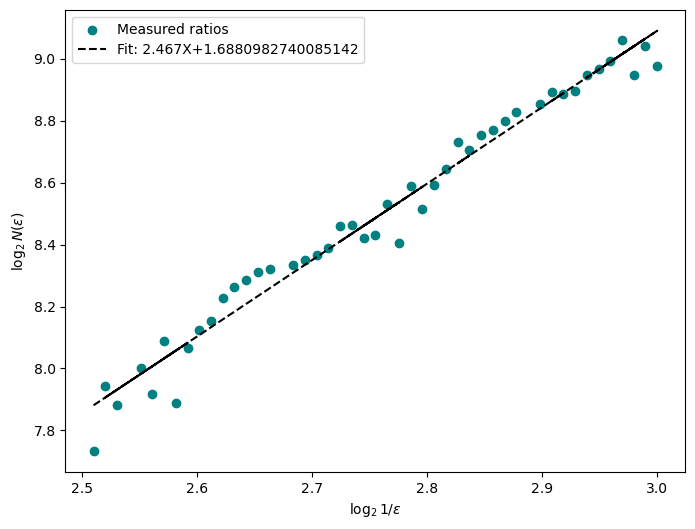

In [43]:
io_data_list = io_data_list_list[3]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(2013, 3)
2.454806288716883


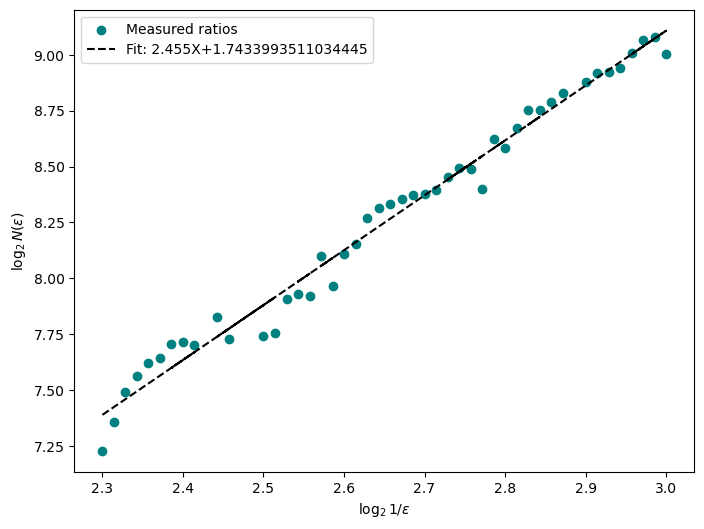

In [44]:
io_data_list = io_data_list_list[4]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.3, min_box_size=-3, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(2161, 3)
2.4728158258344557


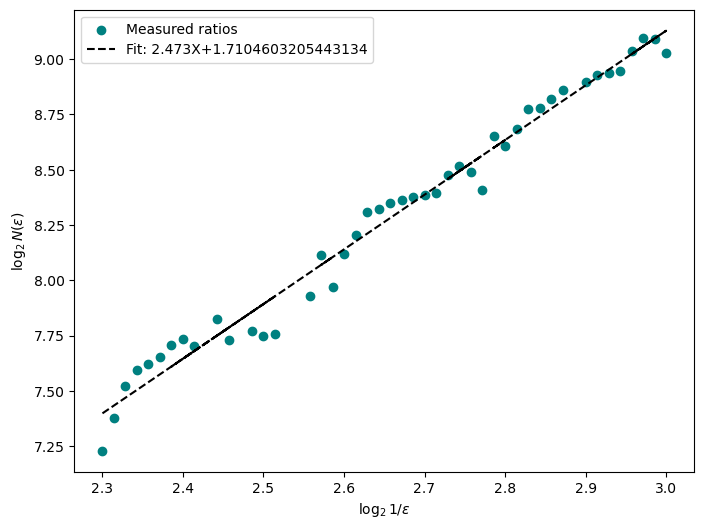

In [45]:
io_data_list = io_data_list_list[5]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
regin_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

regin_min = regin_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.3, min_box_size=-3, n_samples=50, n_offsets=30, plot=True)
print(d)